In [2]:
import pandas as pd
import math
import random
import matplotlib.pyplot as plt
import collections

restaurant_data = pd.read_csv("restaurant.csv")
tennis_data = pd.read_csv("play_tennis.csv")
tennis_data = tennis_data.iloc[:, 1:]
mushroom_data = pd.read_csv("mushroom.csv")
four_data = pd.read_csv("connect-four.csv")
all_vote_data = pd.read_csv("house-votes-84.csv").iloc[:, 1:]
vote_data = pd.read_csv("house-votes-84.csv").iloc[:, 1:]

for f in all_vote_data.columns:
    vote_data = vote_data[vote_data[f]!="?"]

vote_data_missing = all_vote_data.iloc[0:0, :]

for r in all_vote_data.index:
    if r not in vote_data.index:
        vote_data_missing = vote_data_missing.append(all_vote_data.loc[r, :])
        
CURRENT_DATA = vote_data

In [3]:
int_nodes = 0
leaves = 0

class node:
    def __init__(self, name, ntype, h=0, inf=0, depth=0):
        self.name = name
        self.ntype = ntype
        self.h = h
        self.inf = inf
        self.depth = depth
        self.children = {}

In [4]:
def entropy(data):
    classes = {}
    for c in data[data.columns[-1]]:
        if c not in classes:
            classes[c]=0
        classes[c]+=1
    h = 0
    for c in classes:
        p = classes[c]/len(data)
        if p>0:
            h += p*math.log(p, 2)
    return -h

In [5]:
def restrict(data, feature, value):
    return data[data[feature] == value]

In [6]:
def best_feature(data):
    h0 = entropy(data)
    features = {}
    for f in data.columns[0:-1]:
        hf = 0
        for v in set(data[f]):
            d2 = restrict(data, f, v)
            pv = len(d2)/len(data)
            hf += pv*entropy(d2)
        Lf = h0 - hf
        features[f] = Lf
    f = max(features, key=lambda x: features[x])
    return f, features[f]

In [7]:
def decision_tree(data, depth=0):
    global leaves
    global int_nodes
    if entropy(data) == 0:
        c = data.iloc[0, -1]
        leaf = node(c, 'l', depth=depth)
        leaves += 1
        return leaf
    f, inf = best_feature(data)
    n = node(f,'i', h=entropy(data), inf=inf, depth=depth)
    int_nodes += 1
    for value in set(data[f]):
        d2 = restrict(data, f, value)
        if d2.empty:
            continue
        else:
            child = decision_tree(d2, depth+1)
            n.children[value] = child
    return n

root = decision_tree(CURRENT_DATA)

In [8]:
def print_tree(node, t="", parent=None):
    if node.ntype == 'l':
        return "-->" + str(node.name) + " (info gain=" + str(parent.h) + ")\n" 
    else:
        s = t + "* " + node.name + "? (info gain=" + str(node.inf) + ")\n"
        t += "  "
        for val in node.children:
            s += t + "* " + val
            child = node.children[val]
            if child.ntype == "i":
                s += "\n" 
            s += print_tree(child, t + "  ", parent=node)
        return s
# print(print_tree(root))

In [9]:
def classify_row(row_num, data, node):
    while node.ntype != 'l':
        val = data.loc[row_num, node.name]
        node = node.children[val]
    return node.name

def classify(data, node):
    for r in data.index:
        print(str(r) + "-->" + classify_row(r, data, node))
        
def class_miss_helper(row_num, data, node):
    if node.ntype == 'l':
        return [node.name]
    
    val = data.loc[row_num, node.name]
    res = []
    if val == '?':
        for val in node.children:
            res += class_miss_helper(row_num, data, node.children[val])
    else:
        res += class_miss_helper(row_num, data, node.children[val])
    return res

def classify_missing(row_num, data, node):
    res = class_miss_helper(row_num, data, node)
    return random.choice(res)

def accuracy(data, node):
    correct = 0
    total = 0
    res = data.columns[-1]
    for r in data.index:
        if classify_missing(r, data, node) == data.loc[r, res]:
            correct += 1
        total += 1
    return correct/total

# accuracy(all_vote_data, root)

In [10]:
def node_count(node):
    nodes = 1
    if node.ntype == 'i':
        for v in node.children:
            nodes += node_count(node.children[v])
    return nodes

def paths(node):
    if node.ntype == 'i':
        path_len = 0
        for v in node.children:
            path_len += paths(node.children[v])
        return path_len
    else:
        return node.depth
        
def avg_path(node):
    return paths(node)/leaves

# avg_path(root)

In [11]:
def plot(data, node):
    x = []
    y = []
    for r in range(1, len(data.index)-50):
        test_sample = sorted(random.sample(list(data.index), 50))
        train_data = data.loc[:, :]
        test_data = data.loc[test_sample[0]:test_sample[0], :]
        train_data = train_data.drop(test_sample[0])
        for n in test_sample[1:]:
            test_data = test_data.append(data.loc[n, :])
            train_data = train_data.drop(n)
        i = int(random.random()*(len(train_data.index)-r))
        train_data = train_data.iloc[i:i+r, :]
        t = decision_tree(train_data)
        a = accuracy(test_data, t)
        x+=[r]
        y+=[a]
    plt.plot(x, y)
    plt.xlabel('plot size')
    plt.ylabel('accuracy')
    plt.show()

# plot(CURRENT_DATA, root)

In [12]:
def plot_missing(test_data, train_data, node):
    x = []
    y = []
    for r in range(5, 182, 2):
        a = 0
        for i in range(10):
            test_i = int(random.random()*(len(test_data.index)-50))
            train_i = int(random.random()*(len(train_data.index)-r))
            test = test_data.iloc[test_i:test_i+50, :]
            train = train_data.iloc[train_i:train_i+r, :]
            t = decision_tree(train)
            a += accuracy(test, t)
        x+=[r]
        y+=[a/10]
        # print(y)
    plt.plot(x, y)
    plt.xlabel('plot size')
    plt.ylabel('accuracy')
    plt.show()

# plot_missing(vote_data_missing, vote_data, root)

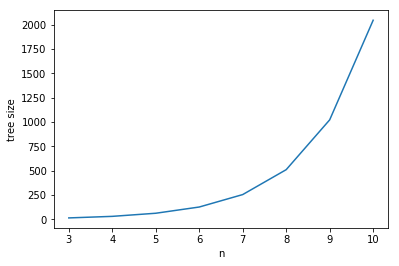

In [13]:
def make_table(n):
    cols = []
    for c in range(n):
        cols += ['c'+str(c)]
    cols += ['res']
    table = pd.DataFrame(index=range(2**n), columns=cols)
    values = table_vals(n, vals=[])
    for x in range(len(table.index)):
        for c in range(n):
            table.iat[x, c] = values[x][c]
        table.iat[x, -1] = values[x].count('1')
    return table
    
def table_vals(n, d="", vals=[]):
    if len(d)==n:
        vals += [d]
        return vals
    table_vals(n, d + '0', vals)
    table_vals(n, d + '1', vals)
    return vals

def plot_tree_growth():
    x = []
    y = []
    for i in range(3, 11):
        t = decision_tree(make_table(i))
        n = node_count(t)
        x += [i]
        y += [n]
    plt.plot(x, y)
    plt.xlabel('n')
    plt.ylabel('tree size')
    plt.show()

plot_tree_growth()

In [15]:
t = decision_tree(make_table(3))
print(print_tree(t))
print(node_count(t))

* c0? (info gain=0.3112781244591327)
  * 0
    * c1? (info gain=0.5)
      * 0
        * c2? (info gain=1.0)
          * 0-->0 (info gain=1.0)
          * 1-->1 (info gain=1.0)
      * 1
        * c2? (info gain=1.0)
          * 0-->1 (info gain=1.0)
          * 1-->2 (info gain=1.0)
  * 1
    * c1? (info gain=0.5)
      * 0
        * c2? (info gain=1.0)
          * 0-->1 (info gain=1.0)
          * 1-->2 (info gain=1.0)
      * 1
        * c2? (info gain=1.0)
          * 0-->2 (info gain=1.0)
          * 1-->3 (info gain=1.0)

15
